<a href="https://colab.research.google.com/github/Zerowl7/data_analys_test/blob/main/Taxi_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

Ключевым аспектом райдхейлинга является цена. Он использует технологию для сбора точных данных отслеживания, чтобы можно было рассчитать справедливую цену в конце поездки. К счастью, наши водители быстро сообщают нам, когда они переплатили, и мы можем использовать эти отзывы для улучшения нашего продукта.

Пожалуйста, проанализируйте набор данных, чтобы определить лучшие возможности для сокращения количества билетов с завышенной ценой, и представьте свои результаты. Пожалуйста, предоставьте нам PDF-файл/документ с выводами. Наконец, вы не должны тратить на этот анализ более 8 часов.


distance - ride distance

duration - ride duration

gps_confidence- indicator for good GPS connection (1 - good one, 0 - bad one)

entered_by- who entered the address

b_state- state of a ride (finished implies that the ride was actually done)

dest_change_number- number of destination changes by a rider

predicted distance - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car

predicted duration - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car

prediction_price_type- internal variable for the type of prediction:

upfront, prediction - prediction happened before the ride

upfront_destination_changed - prediction happened after rider changed destination during the ride

change_reason_pricing - records due to whose action the price changed

ticket_id_new - id for customer support ticket

Способ захватить файл с гугл-драйва

# Вывод аналитической задачи

У нас больше всего работает неправильно вича upront, (предсказание произошло перед поездкой)

также подстраивать нужно fraud_bin,

Также сигнал gps влияет на то что цена может быть очень большой. Необходимо улучшить оснащение автомобилей.

Ещё те кто катается с tecno больше всего отсылает данных с большим чеком, проблема может быть с этой системой.

Я использовал sharp и catboost, чтобы выявить значимость фичей и их зависимости

Сильно влияет duration и distance, можно еще обучить catboost для нахождении ошибки


# Импорт данных


In [ ]:
! gdown --id 1ZNLnbwS3hnhjy3_6CYBcSu_72PCEcnVd

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZNLnbwS3hnhjy3_6CYBcSu_72PCEcnVd
To: /content/Analytical_Task_2 (taxi startup).csv
100% 792k/792k [00:00<00:00, 76.8MB/s]


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('Analytical_Task_2 (taxi startup).csv')

In [ ]:
df.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 6:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


In [ ]:
df.columns

Index(['order_id_new', 'order_try_id_new', 'calc_created', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration', 'change_reason_pricing',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'overpaid_ride_ticket', 'fraud_score'],
      dtype='object')

'overpaid_ride_ticket' - наш таргет

In [ ]:
df['overpaid_ride_ticket'].value_counts()

0    4606
1     337
Name: overpaid_ride_ticket, dtype: int64

In [ ]:
len(df)

4943

# преобразование даты

In [ ]:
df['calc_created'] = pd.to_datetime(df['calc_created'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
df['calc_created'].agg(['min','max'])

min   2020-02-02 00:01:16
max   2020-03-13 23:52:07
Name: calc_created, dtype: datetime64[ns]

In [ ]:
df.isna().mean()

order_id_new             0.000000
order_try_id_new         0.000000
calc_created             0.000000
metered_price            0.004046
upfront_price            0.310338
distance                 0.000000
duration                 0.000000
gps_confidence           0.000000
entered_by               0.000000
b_state                  0.000000
dest_change_number       0.000000
prediction_price_type    0.004046
predicted_distance       0.004046
predicted_duration       0.004046
change_reason_pricing    0.939713
ticket_id_new            0.000000
device_token             1.000000
rider_app_version        0.003237
order_state              0.000000
order_try_state          0.000000
driver_app_version       0.000000
driver_device_uid_new    0.000000
device_name              0.000000
eu_indicator             0.000000
overpaid_ride_ticket     0.000000
fraud_score              0.558163
dtype: float64

# Catboost

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 88 kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
df = df[(~df['prediction_price_type'].isna())&(~df['rider_app_version'].isna())].copy()

In [ ]:
train = df.sample(frac=0.7, random_state=42).copy()

Выкидываем дату переведенную в Unix

In [ ]:
df['dt_unix'] = df['calc_created'].astype(int) / 10**9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


In [ ]:
train = df.sample(frac=0.7,random_state=42).copy()

In [ ]:
val = df[~df.index.isin(train.index)].copy()

In [ ]:
len(train)

3446

In [ ]:
len(val)

1477

'order_id_new', 'order_try_id_new', 'calc_created', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration', 'change_reason_pricing',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'overpaid_ride_ticket', 'fraud_score'

In [ ]:
df.select_dtypes(include='object').columns

Index(['entered_by', 'b_state', 'prediction_price_type',
       'change_reason_pricing', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'device_name'],
      dtype='object')

In [ ]:
X_col = ['order_id_new', 'order_try_id_new', 'metered_price', 'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by', 'b_state', 'dest_change_number', 'prediction_price_type', 'predicted_distance', 'predicted_duration', 'ticket_id_new', 'device_token', 'rider_app_version', 'order_state', 'order_try_state', 'driver_app_version', 'driver_device_uid_new', 'device_name', 'eu_indicator', 'fraud_score']
y_col = ['overpaid_ride_ticket']
cat_features = ['entered_by', 'b_state', 'prediction_price_type',
        'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'device_name']

Модель

In [ ]:
model = CatBoostClassifier(learning_rate=0.05,
                           eval_metric='AUC', 
                           cat_features= cat_features,
                           verbose=100)

In [ ]:
model.fit(train[X_col], train[y_col], eval_set = (val[X_col], val[y_col]))

0:	test: 0.8195660	best: 0.8195660 (0)	total: 61ms	remaining: 1m
100:	test: 0.8598211	best: 0.8719419 (30)	total: 1.39s	remaining: 12.4s
200:	test: 0.8560291	best: 0.8719419 (30)	total: 2.72s	remaining: 10.8s
300:	test: 0.8507548	best: 0.8719419 (30)	total: 4.65s	remaining: 10.8s
400:	test: 0.8476068	best: 0.8719419 (30)	total: 7.03s	remaining: 10.5s
500:	test: 0.8421778	best: 0.8719419 (30)	total: 9.86s	remaining: 9.82s
600:	test: 0.8370834	best: 0.8719419 (30)	total: 12.8s	remaining: 8.52s
700:	test: 0.8339965	best: 0.8719419 (30)	total: 15.5s	remaining: 6.61s
800:	test: 0.8299239	best: 0.8719419 (30)	total: 18.9s	remaining: 4.7s
900:	test: 0.8303484	best: 0.8719419 (30)	total: 21.9s	remaining: 2.41s
999:	test: 0.8312622	best: 0.8719419 (30)	total: 24.5s	remaining: 0us

bestTest = 0.871941918
bestIteration = 30

Shrink model to first 31 iterations.


In [ ]:
fi = pd.DataFrame({'feature': X_col,'fi':model.feature_importances_})

In [ ]:
df = pd.read_csv('Analytical_Task_2 (taxi startup).csv')

In [ ]:
df['calc_created'] = pd.to_datetime(df['calc_created'],format='%Y-%m-%d %H:%M:%S')

# Фичи

In [ ]:
fi.sort_values('fi', ascending=False)

,feature,fi
2,metered_price,28.109539
22,fraud_score,14.652075
21,eu_indicator,9.275214
5,duration,6.616308
6,gps_confidence,6.043783
10,prediction_price_type,6.006761
3,upfront_price,5.454879
4,distance,4.808296
19,driver_device_uid_new,4.171626
18,driver_app_version,3.535096


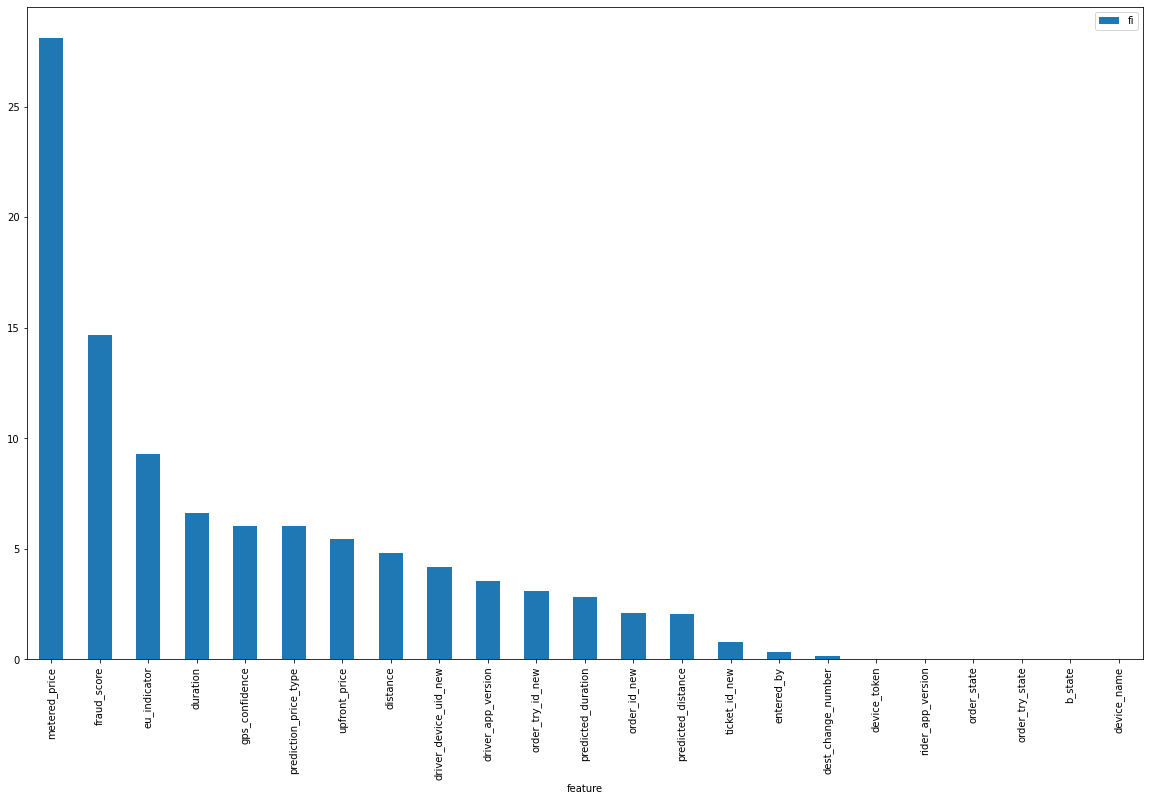

In [ ]:
fi.sort_values('fi', ascending=False).set_index('feature').plot(kind='bar', figsize=(20,12))

# Цена

In [ ]:
df['metered_price']

0           4.04
1           6.09
2           4.32
3       72871.72
4       20032.50
          ...   
4938       10.89
4939     8789.28
4940        7.50
4941        3.06
4942    29244.10
Name: metered_price, Length: 4923, dtype: float64

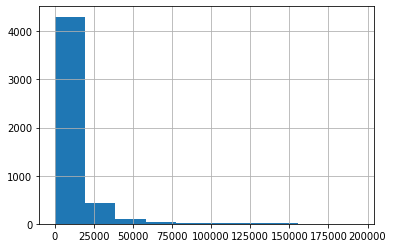

In [ ]:
df['metered_price'].hist()

# Q_cut

In [ ]:
df['metered_price_bin'] = pd.qcut(df['metered_price'], 5)

In [ ]:
df['overpaid_ride_ticket']

0       0
1       0
2       0
3       1
4       0
       ..
4938    0
4939    0
4940    0
4941    0
4942    0
Name: overpaid_ride_ticket, Length: 4923, dtype: int64

In [ ]:
df.groupby('metered_price_bin')['overpaid_ride_ticket'].agg(['count', 'mean'])

,count,mean
metered_price_bin,,
"(1.999, 4.72]",992,0.000000
"(4.72, 8.25]",978,0.005112
"(8.25, 6000.0]",1291,0.040279
"(6000.0, 13835.1]",677,0.138848
"(13835.1, 194483.52]",985,0.188832


985 поездок имеют слишком дорогую цену

# Поиск зависимости переменных

In [ ]:
df.groupby('prediction_price_type')['overpaid_ride_ticket'].agg(['count', 'mean'])

,count,mean
prediction_price_type,,
prediction,1279,0.173573
upfront,3432,0.032634
upfront_destination_changed,208,0.014423
upfront_waypoint_changed,4,0.000000


In [ ]:
df.groupby('eu_indicator')['overpaid_ride_ticket'].agg(['count', 'mean'])

,count,mean
eu_indicator,,
0,2173,0.149103
1,2750,0.004727


Весомая фича

In [ ]:
df['fraud_bin'] = pd.qcut(df['fraud_score'], 5,duplicates='drop')

In [ ]:
df.groupby('fraud_bin')['overpaid_ride_ticket'].agg(['count', 'mean'])

,count,mean
fraud_bin,,
"(-14225.001, -1025.6]",437,0.013730
"(-1025.6, -426.0]",439,0.004556
"(-426.0, -184.0]",435,0.006897
"(-184.0, -36.0]",437,0.009153
"(-36.0, 49.0]",434,0.004608


In [ ]:
df['device_name']

0          Xiaomi Redmi 6
1        Samsung SM-G965F
2        Samsung SM-A530F
3                TECNO-Y6
4              Itel W5504
              ...        
4938       HUAWEI LYA-L29
4939     Samsung SM-G928F
4940       HUAWEI AMN-LX9
4941    TP-Link Neffos X1
4942     Samsung SM-A260F
Name: device_name, Length: 4943, dtype: object

# Техника и ее количество

In [ ]:
t = df.groupby('device_name')['overpaid_ride_ticket'].agg(['count', 'mean'])

In [ ]:
t.sort_values('count', ascending=False)

,count,mean
device_name,,
TECNO MOBILE LIMITED TECNO B1p,108,0.259259
HMD Global Nokia 2.2,98,0.040816
"iPhone8,1",91,0.010989
TECNO F3,86,0.151163
HUAWEI MAR-LX1A,73,0.000000
...,...,...
Samsung SM-J100H,1,0.000000
Fero A5000,1,0.000000
Samsung SM-J110H,1,0.000000


Android_market share - 70%

In [ ]:
def device_cat (device_name):
  if 'tecno' in device_name.lower():
    return "tecno"
  if 'iphone' in device_name.lower():
    return "iphone"
  if 'lg' in device_name.lower():
    return "lg"
  if 'samsung' in device_name.lower():
    return "samsung"
  if 'htc' in device_name.lower():
    return "htc"
  if 'nokia' in device_name.lower():
    return "nokia"
  if 'xiaomi' in device_name.lower():
    return "xiaomi"
  if 'huawei' in device_name.lower():
    return "huawei"

  return 'misc'

In [ ]:
df['device_group'] = df['device_name'].apply(device_cat)

# Разбиваем на группы телефоны

In [ ]:
df.groupby('device_group')['overpaid_ride_ticket'].agg(['count', 'mean'])

,count,mean
device_group,,
htc,16,0.312500
huawei,724,0.019337
iphone,426,0.021127
lg,39,0.000000
misc,703,0.095306
nokia,158,0.113924
samsung,1683,0.038622
tecno,933,0.167203
xiaomi,261,0.011494


In [ ]:
df[df['device_group'] == 'misc']['device_name'].value_counts()

HUAWEI MAR-LX1A                          73
HUAWEI KOB-L09                           59
HUAWEI ANE-LX1                           55
Itel S12                                 50
HUAWEI ATU-L21                           39
                                         ..
Asus ASUS_Z012D                           1
Sony E5663                                1
LAVA iris870                              1
INFINIX MOBILITY LIMITED Infinix X623     1
Lava LAVA_R1                              1
Name: device_name, Length: 209, dtype: int64

In [ ]:
df.groupby('device_group')['overpaid_ride_ticket'].agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
device_group,,
htc,16,0.312500
tecno,933,0.167203
nokia,158,0.113924
misc,703,0.095306
samsung,1683,0.038622
iphone,426,0.021127
huawei,724,0.019337
xiaomi,261,0.011494
lg,39,0.000000


Techno

nokia

не очень хорошо

# Скорость

In [ ]:
df['dur_bin'] = pd.qcut(df['duration'], 5)

In [ ]:
df.groupby('dur_bin')['overpaid_ride_ticket'].agg(['count', 'mean'])

,count,mean
dur_bin,,
"(-0.001, 517.0]",992,0.033266
"(517.0, 863.0]",987,0.030395
"(863.0, 1304.0]",988,0.051619
"(1304.0, 2241.2]",987,0.105370
"(2241.2, 22402.0]",989,0.120324


# Xgboost_Shap

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.4 MB/s 


In [ ]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[X_col])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], train[X_col].iloc[0,:])

Красные фичи повышают вероятность того, что цена слишком дорогая

All-NaN slice encountered


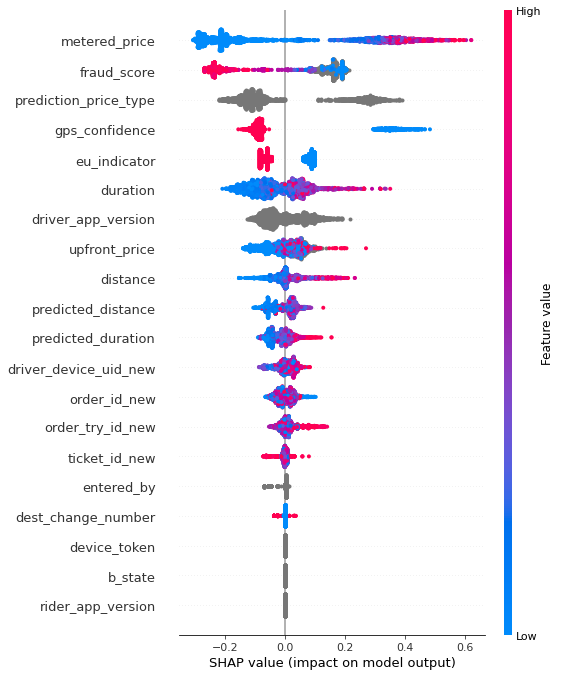

In [ ]:
shap.summary_plot(shap_values, train[X_col])

Категориальная фича - серая

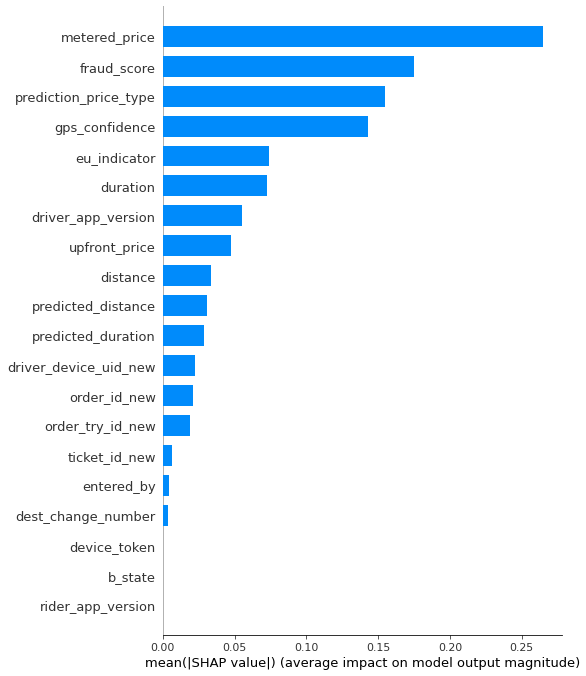

In [ ]:
shap.summary_plot(shap_values, train[X_col], plot_type="bar")

In [ ]:
df.columns

Index(['order_id_new', 'order_try_id_new', 'calc_created', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration', 'change_reason_pricing',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'overpaid_ride_ticket', 'fraud_score',
       'device_group', 'dur_bin'],
      dtype='object')

In [ ]:
[col for col in df.columns if 'price' in col]

['metered_price', 'upfront_price', 'prediction_price_type']

# Distance and duration

In [ ]:
df['distance_err'] = df['distance'] - df['predicted_distance']

In [ ]:
df['duration_err'] = df['duration'] - df['predicted_duration']

In [ ]:
df['distance_err_pct'] = np.abs(df['distance_err'])/df['distance']
df['duration_err_pct'] = np.abs(df['duration_err'])/df['duration']

# Избавляемся от inf

In [ ]:
df.replace([np.inf, -np.inf], np.nan)['duration_err_pct'].agg(['mean', 'median'])

mean      3.195506
median    0.279104
Name: duration_err_pct, dtype: float64

In [ ]:
df.replace([np.inf, -np.inf], np.nan)['distance_err_pct'].agg(['mean', 'median'])

mean      37.434295
median     0.163026
Name: distance_err_pct, dtype: float64

In [ ]:
df['distance_err_bin'] = pd.qcut(df['distance_err'], 5)

# Вывод

In [ ]:
df.groupby('distance_err_bin')[['overpaid_ride_ticket', 'upfront_price', 'metered_price']].agg(['count', 'mean'])

overpaid_ride_ticket           upfront_price  \
                                     count      mean         count   
distance_err_bin                                                     
(-341860.001, -754.8]                  985  0.072081           622   
(-754.8, 0.0]                         1007  0.065541           693   
(0.0, 581.4]                           962  0.028067           784   
(581.4, 2466.0]                        984  0.033537           743   
(2466.0, 112012.0]                     985  0.142132           567   

                                   metered_price                
                              mean         count          mean  
distance_err_bin                                                
(-341860.001, -754.8]  9338.362058           985   6481.735442  
(-754.8, 0.0]          2072.340693          1007   5745.271192  
(0.0, 581.4]           1255.807270           962   3210.857422  
(581.4, 2466.0]        2696.943607           984   5552.151494  
(2466.0, 112012.0]     6964.358201           985  18938.390640

upfront голосует за маленькую цену, а на деле она большая

In [ ]:
df['duration_err_bin'] = pd.qcut(df['duration_err'], 5)

In [ ]:
df.groupby('duration_err_bin')[['overpaid_ride_ticket', 'upfront_price', 'metered_price']].agg(['count', 'mean'])

overpaid_ride_ticket           upfront_price  \
                                    count      mean         count   
duration_err_bin                                                    
(-20081.001, -122.0]                  986  0.070994           729   
(-122.0, 34.0]                        988  0.033401           880   
(34.0, 257.0]                         982  0.027495           787   
(257.0, 845.0]                        983  0.090539           624   
(845.0, 18086.0]                      984  0.119919           389   

                                   metered_price                
                              mean         count          mean  
duration_err_bin                                                
(-20081.001, -122.0]   7674.807545           986   6989.042434  
(-122.0, 34.0]          780.946477           988   1707.660152  
(34.0, 257.0]          1541.834180           982   3134.069287  
(257.0, 845.0]         3527.216026           983   8091.943194  
(845.0, 18086.0]      11530.057841           984  20087.473496

Те же самые зависимости обнаруживаем с ценой